# American Sign Language Detection Project
In this project we will be designing and implementing a Neural Network that can take as input 28x28 pixel images of ASL(American Sign Language) letters and output the letter associated with the hand position.

## 1 Introduction and Setup

### 1.1 Module Imports
We will be using the following imports in order to design and develop the models for this project

In [12]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from packaging import version
import io
import itertools

# Sklearn Imports
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV

# Keras and Tensorflow imports
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Load the TensorBoard notebook extension and related libraries
import datetime, os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)


# tensorboard(
#     logs_base_dir,
#     reload_multifile = True,
#     reload_interval = 5
# )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 1.2 Data Import
We will be using a dataset found on kaggle called the Sign Language MNIST dataset. It can be found at https://www.kaggle.com/datasets/datamunge/sign-language-mnist. The data is already split into training and testing data for us so the use of the train_test_split module will not be required.

In [13]:
# Both files can be found in the data subfolder
train = pd.read_csv('data/sign_mnist_train.csv')
test = pd.read_csv('data/sign_mnist_test.csv')

print(train.shape)
print(test.shape)

(27455, 785)
(7172, 785)


In [14]:
# Using this cell we can see what the format of the data is.
# We can see that the data consists of the label along with 784 pixel values indicating
# the grayscale value of each pixel on a scale of 0-255
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### 1.3 Data Distribution
Using the following code we can visualize how diverse the training data is.
This graph shows the frequency of each of the 24 different classes in our dataset

<Axes: xlabel='label', ylabel='count'>

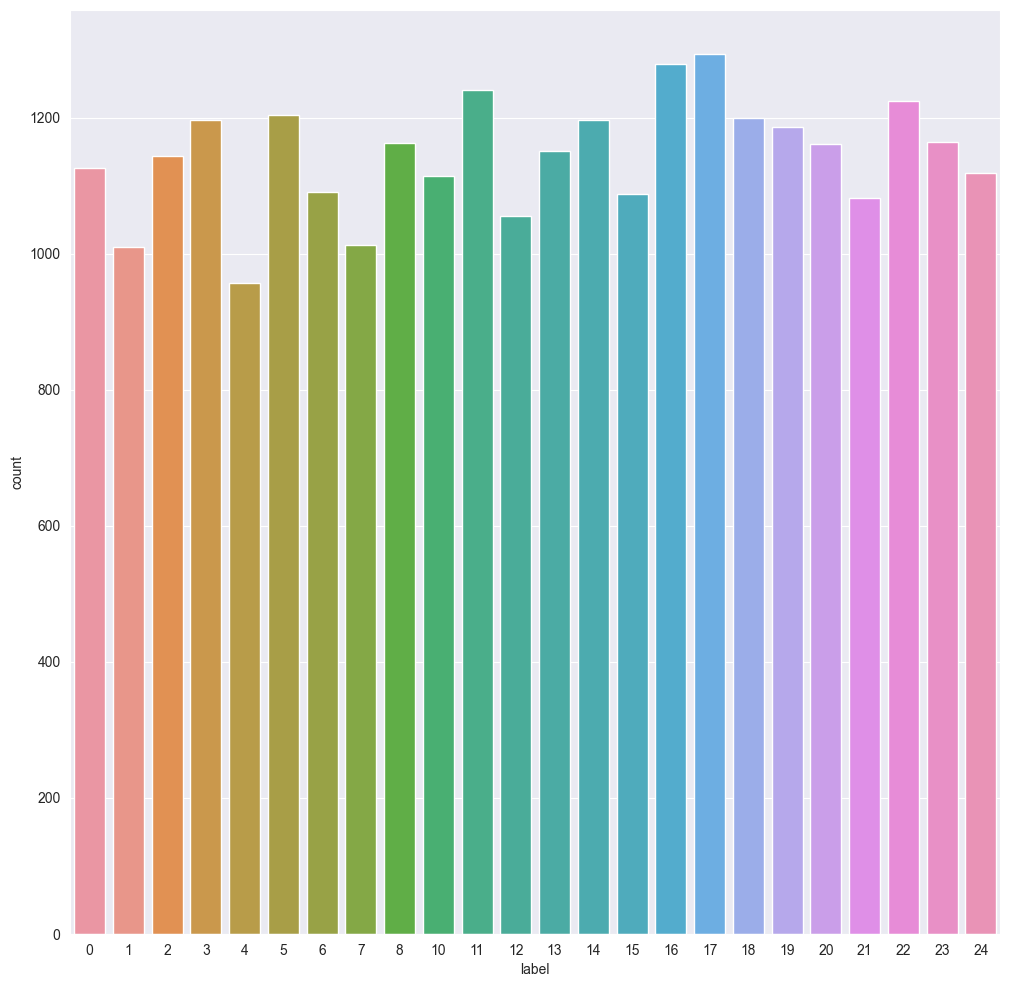

In [15]:
plt.figure(figsize=(12,12))
sns.set_style('darkgrid')
sns.countplot(x=train['label'])

### 1.4 Data Preprocessing
There a few imperfections in the way the data is set up in order for us to set up our models. The features are currently grayscale values from 0-255 and the preferable next step is to normalize the data. This would take the scale and convert the values from 0-255 to 0-1.

In [16]:
# Separation of the features and the label
y_train = train['label']
y_test = test['label']

X_train = train.drop('label', axis=1)
X_test = test.drop('label', axis=1)

In [17]:
# Normalization of the input data to a 0-1 scale
X_train /= 255
X_test /= 255

In [18]:
# Binarization of the data

labeller = LabelBinarizer()
y_train = labeller.fit_transform(y_train)
y_test = labeller.fit_transform(y_test)

In [19]:
# Reshaping the data into the matrices required for Convolutional Neural Networks
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

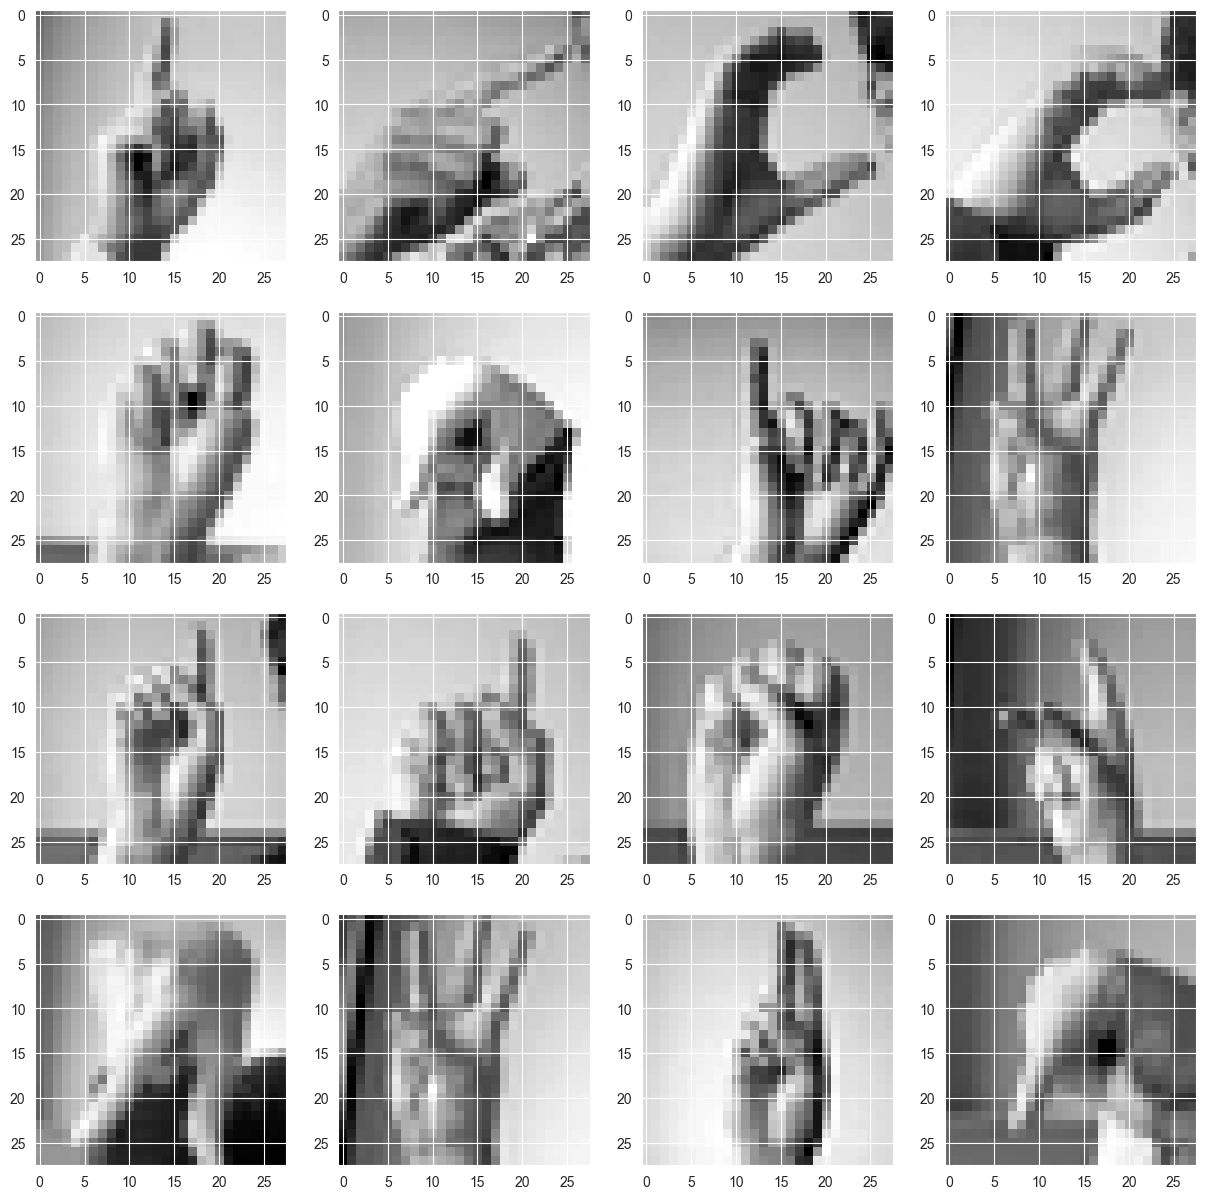

In [20]:
# Displaying some examples of the input data

plt.figure(figsize=(15,15))

x = 4
y = 4

for i in range(16):
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')

plt.show()

## 2. Model and Hyperparameter Setup

### 2.1 Hyperparameters
The following hyperparameters are values that can be tweaked by the data scientist in order to help the model reach higher performance metrics.

In [21]:
# Data_generator is an iterator that can iterate over the datasets
data_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    horizontal_flip=False,
    vertical_flip=False
)

data_generator.fit(X_train)

In [22]:
# The modular learning rate allows gradient descent to converge much quicker
# than if we were to use a static learning_rate

learning_rate = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=.5,
    min_lr=.00001
)

## 3. Model Iteration, Training, and Testing
In this section we will be creating different models while iterating on them to make improvements in between runs. This will allow us to make small tweaks that will improve the performance metrics that we will be using to measure the sucess of the model

### 3.1 Model 1

In [23]:
# Model 1 is a basic CNN with only Convolutional Layers and Max Pooling Layers 
# before the required Flatten and Dense Layers that shape our one-hot encoded
# output
model_1 = Sequential()
model_1.add(Conv2D(20,
                  kernel_size=(3,3),
                  activation='tanh',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_1.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_1.add(Conv2D(30,
                  kernel_size=(3,3),
                  activation='tanh',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))


model_1.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_1.add(Flatten())
model_1.add(Dense(units=24, activation='softmax'))

In [24]:
# Compiling Model 1

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 30)        5430      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 30)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1470)              0         
                                                                 
 dense (Dense)               (None, 24)                3

In [25]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.
 
  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
 
  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
 
  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
 
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

class_names =["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

def plot_to_image(figure):
  """Converts the matplotlib plot to a PNG image and returns it.
  The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  print(image.shape)
  image = tf.expand_dims(image, 0)
  return image

# Sets up a timestamped log directory
logdir = "logs/image_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Create file Writer for Confusion Metrics
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model_1.predict(X_test)
  test_pred = np.argmax(test_pred_raw, axis=1)
  y_test_cls = np.argmax(y_test, axis=1)
 
  # Calculate the confusion matrix.
  cm = confusion_matrix(y_test_cls, test_pred)
 
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)
 
  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)
 
# Define the per-epoch callback to plot confusion metrics after each epoch.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [26]:
%tensorboard --logdir logs/image_2 --reload_multifile True --reload_interval 5

history = model_1.fit(data_generator.flow(X_train, y_train, batch_size=128), 
                    epochs=10, 
                    # verbose=0, # Suppress chatty output and use Tensorboard instead
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard_callback, cm_callback],
                    )

Reusing TensorBoard on port 6006 (pid 26212), started 6 days, 23:12:42 ago. (Use '!kill 26212' to kill it.)

Epoch 1/10
225/225 [==============================] - 2s 7ms/step
(800, 800, 4)
215/215 [==============================] - 21s 93ms/step - loss: 2.0702 - accuracy: 0.4071 - val_loss: 0.8382 - val_accuracy: 0.7709
Epoch 2/10
225/225 [==============================] - 1s 5ms/step
(800, 800, 4)
215/215 [==============================] - 18s 83ms/step - loss: 0.9155 - accuracy: 0.7309 - val_loss: 0.4213 - val_accuracy: 0.8763
Epoch 3/10
225/225 [==============================] - 1s 5ms/step
(800, 800, 4)
215/215 [==============================] - 17s 80ms/step - loss: 0.5961 - accuracy: 0.8271 - val_loss: 0.3280 - val_accuracy: 0.9085
Epoch 4/10
225/225 [==============================] - 2s 8ms/step
(800, 800, 4)
215/215 [==============================] - 21s 96ms/step - loss: 0.4454 - accuracy: 0.8697 - val_loss: 0.2414 - val_accuracy: 0.9406
Epoch 5/10
225/225 [==============================] - 2s 9ms/step
(800, 800, 4)
215/215 [==============================] - 22s 104ms/step - loss: 0.

In [27]:
# Displaying the accuracy value for Model 1
print("Accuracy: ", model_1.evaluate(X_test, y_test)[1]*100, "%")

225/225 [==============================] - 1s 6ms/step - loss: 0.0890 - accuracy: 0.9819
Accuracy:  98.18739295005798 %


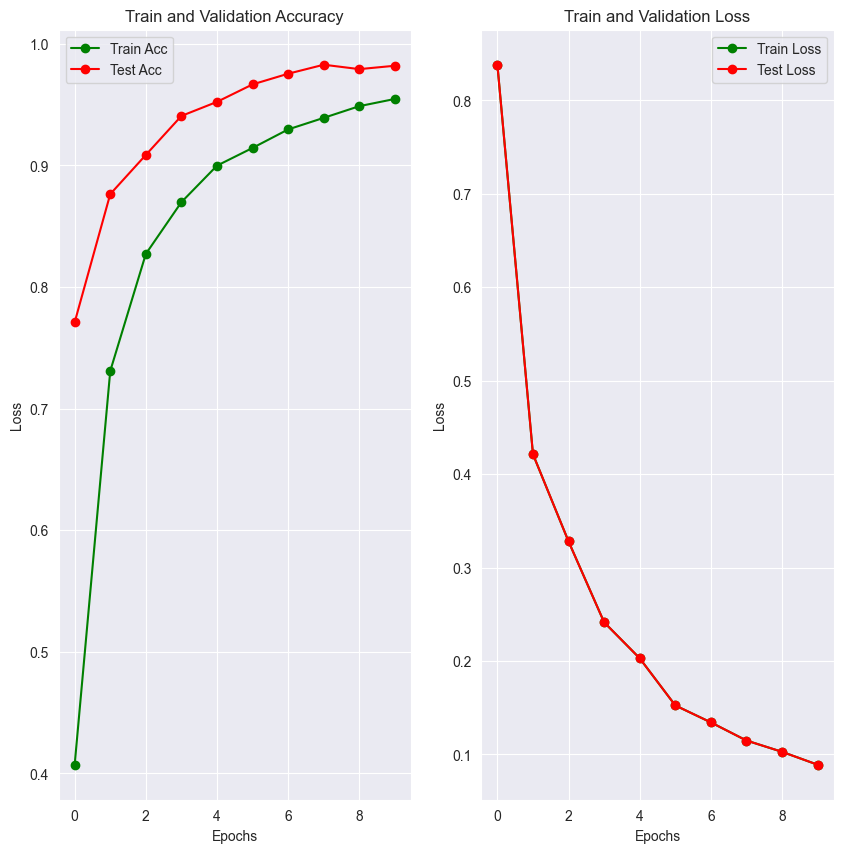

In [28]:
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history.history['accuracy']
train_loss= history.history['loss']
vall_acc= history.history['val_accuracy']
vall_loss=history.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

### 3.2 Model 2
In order to improve the performance, we decided to increase the size of the convolutional layers to facilitate better fitting of the data, hopefully without overfitting.

In [29]:

model_2 = Sequential()
model_2.add(Conv2D(25,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_2.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_2.add(Conv2D(35,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))


model_2.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_2.add(Flatten())
model_2.add(Dense(units=24, activation='softmax'))

In [30]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 25)        250       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 25)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 35)        7910      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 35)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1715)              0         
                                                                 
 dense_1 (Dense)             (None, 24)               

In [31]:
history_2 = model_2.fit(data_generator.flow(X_train, y_train, batch_size=128), 
                    epochs=10, 
                    validation_data=(X_test, y_test),
                    # callbacks=[learning_rate]
                    )

Epoch 1/10
215/215 [==============================] - 18s 83ms/step - loss: 2.1903 - accuracy: 0.3662 - val_loss: 0.9734 - val_accuracy: 0.6885
Epoch 2/10
215/215 [==============================] - 17s 80ms/step - loss: 0.9945 - accuracy: 0.6965 - val_loss: 0.5637 - val_accuracy: 0.8180
Epoch 3/10
215/215 [==============================] - 18s 82ms/step - loss: 0.6731 - accuracy: 0.7967 - val_loss: 0.3880 - val_accuracy: 0.8745
Epoch 4/10
215/215 [==============================] - 17s 80ms/step - loss: 0.5376 - accuracy: 0.8336 - val_loss: 0.2931 - val_accuracy: 0.9076
Epoch 5/10
215/215 [==============================] - 18s 83ms/step - loss: 0.4190 - accuracy: 0.8703 - val_loss: 0.2097 - val_accuracy: 0.9416
Epoch 6/10
215/215 [==============================] - 17s 77ms/step - loss: 0.3372 - accuracy: 0.8962 - val_loss: 0.1934 - val_accuracy: 0.9400
Epoch 7/10
215/215 [==============================] - 18s 82ms/step - loss: 0.2955 - accuracy: 0.9112 - val_loss: 0.1706 - val_accuracy:

In [32]:
print("Accuracy: ", model_2.evaluate(X_test, y_test)[1]*100, "%")

225/225 [==============================] - 2s 10ms/step - loss: 0.1446 - accuracy: 0.9619
Accuracy:  96.193528175354 %


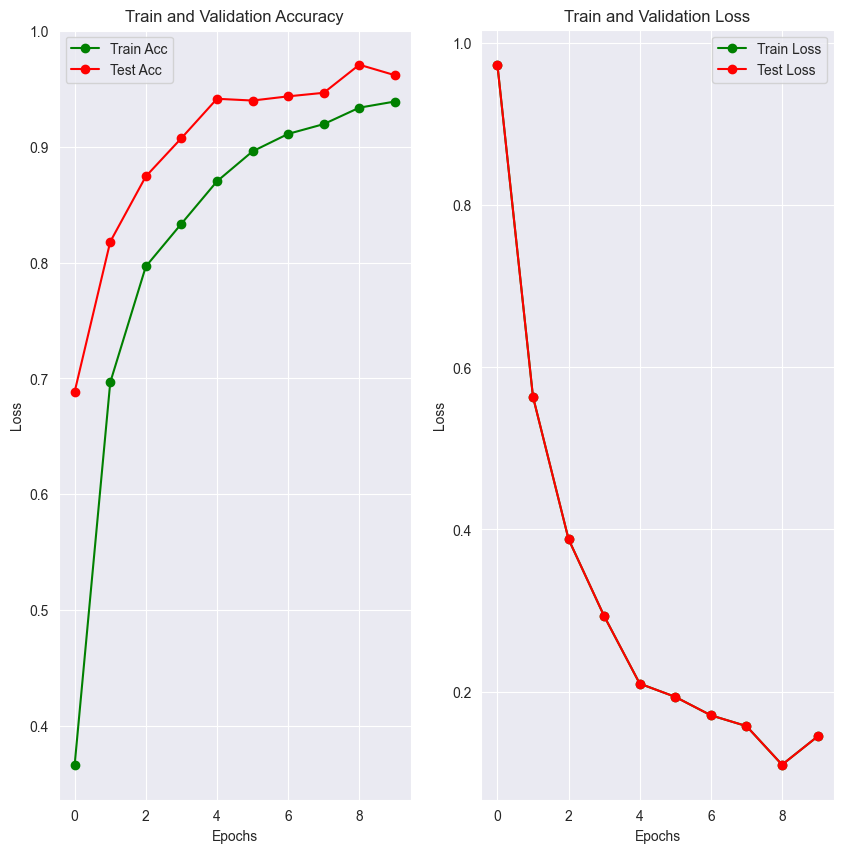

In [33]:
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history_2.history['accuracy']
train_loss= history_2.history['loss']
vall_acc= history_2.history['val_accuracy']
vall_loss=history_2.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

We can see from this graph that in accuracy is always increasing, the test accuracy as well as the loss is stuttering slightly towards the end. This could be an indication of overfitting. We will attempt to fix this is in the next iteration of the model

### 3.3 Model 3
In order to improve the model we will be attempting to introduce batch normalization and dropout. This is with the intention of reducing any overfitting that would cause the accuracy and loss graphs that we can see in the last iteration

In [34]:
# Adjusting the model to include normalization and dropout
model_3 = Sequential()
model_3.add(Conv2D(30,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_3.add(BatchNormalization())

model_3.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_3.add(Conv2D(40,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_3.add(Dropout(.2))
model_3.add(BatchNormalization())

model_3.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_3.add(Flatten())
model_3.add(Dense(units=24, activation='softmax'))

In [35]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 30)        300       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 30)       120       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 30)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 40)        10840     
                                                                 
 dropout (Dropout)           (None, 14, 14, 40)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 40)      

In [36]:
history_3 = model_3.fit(data_generator.flow(X_train, y_train, batch_size=128), 
                        epochs=10, 
                        validation_data=(X_test, y_test), 
                        callbacks=[learning_rate])

Epoch 1/10
215/215 [==============================] - 38s 170ms/step - loss: 1.0441 - accuracy: 0.6862 - val_loss: 2.6279 - val_accuracy: 0.1578 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 32s 150ms/step - loss: 0.2468 - accuracy: 0.9214 - val_loss: 1.1509 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 32s 148ms/step - loss: 0.1371 - accuracy: 0.9573 - val_loss: 0.2080 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 31s 145ms/step - loss: 0.0890 - accuracy: 0.9712 - val_loss: 0.2113 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 32s 149ms/step - loss: 0.0762 - accuracy: 0.9761 - val_loss: 0.1548 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 36s 167ms/step - loss: 0.0621 - accuracy: 0.9791 - val_loss: 0.0519 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 7/10
215/215 [==============================] 

In [37]:
print("Accuracy of the model is: ", model_3.evaluate(X_test, y_test)[1]*100, '%')

225/225 [==============================] - 3s 11ms/step - loss: 0.0504 - accuracy: 0.9849
Accuracy of the model is:  98.49414229393005 %


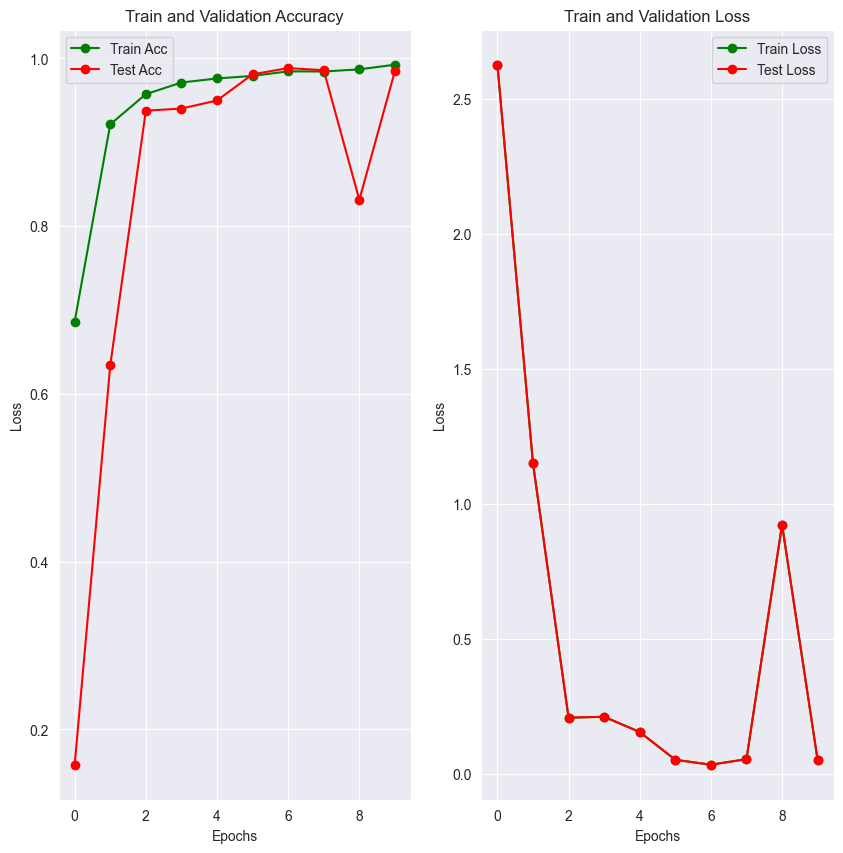

In [38]:
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history_3.history['accuracy']
train_loss= history_3.history['loss']
vall_acc= history_3.history['val_accuracy']
vall_loss=history_3.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()